In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 145
# J&J Quarterly EPS since January 1960 to  december 1980
df = pd.read_csv('../data/jj.csv')
df.tail() # shape (84, 2)

,date,data
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [3]:
train = df.iloc[:-4]
test= df.iloc[-4:]

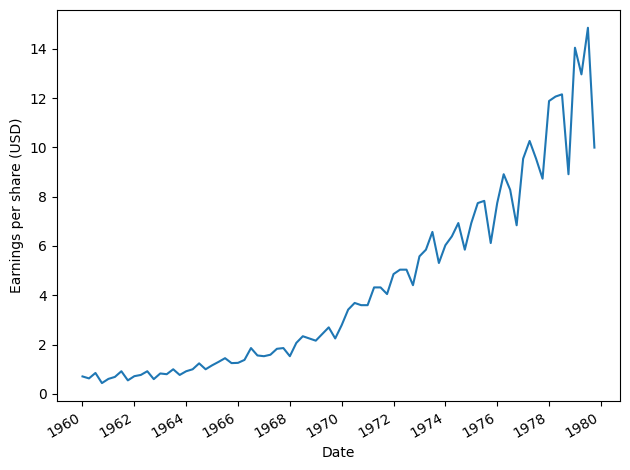

In [4]:
# Figure 7.5 in pg 147

fig, ax = plt.subplots()

ax.plot(train.date, train['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


In [6]:
ad_fuller_result = adfuller(train['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 4.990525443391484
p-value: 1.0


In [9]:
df_diff = np.diff(train['data'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Impact of differencing
std_1 = df_diff.std()
print(f'Standard deviation of first-order differencing series is {std_1}')

ADF Statistic: 1.0549818780548506
p-value: 0.9948134914948294
Standard deviation of first-order differencing series is 1.150594241574943


In [10]:
df_diff_diff = np.diff(df_diff, n=1)

ad_fuller_result = adfuller(df_diff_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# Impact of differencing
std_2 = df_diff_diff.std()
print(f'Standard deviation of second-order differencing series is {std_2}')

ADF Statistic: -6.7833124530769835
p-value: 2.467846485128343e-09
Standard deviation of second-order differencing series is 1.860900987166403


## d=2, D=0

***************************************************************************
Pick a Model and analyze residuals

SARIMA(3,2,3)(0,0,0)_4, trying to recreate ARIMA(3,2,3)

In [13]:
SARIMA_model = SARIMAX(train['data'], order=(3,2,3), seasonal_order=(0,0,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)#, method='nm') # method='powell'

print(SARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   80
Model:               SARIMAX(3, 2, 3)   Log Likelihood                 -50.639
Date:                Tue, 10 Feb 2026   AIC                            115.279
Time:                        19:36:26   BIC                            131.776
Sample:                             0   HQIC                           121.883
                                 - 80                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      0.037    -27.057      0.000      -1.072      -0.927
ar.L2         -0.9870      0.040    -24.470      0.000      -1.066      -0.908
ar.L3         -0.9746      0.027    -36.264      0.0

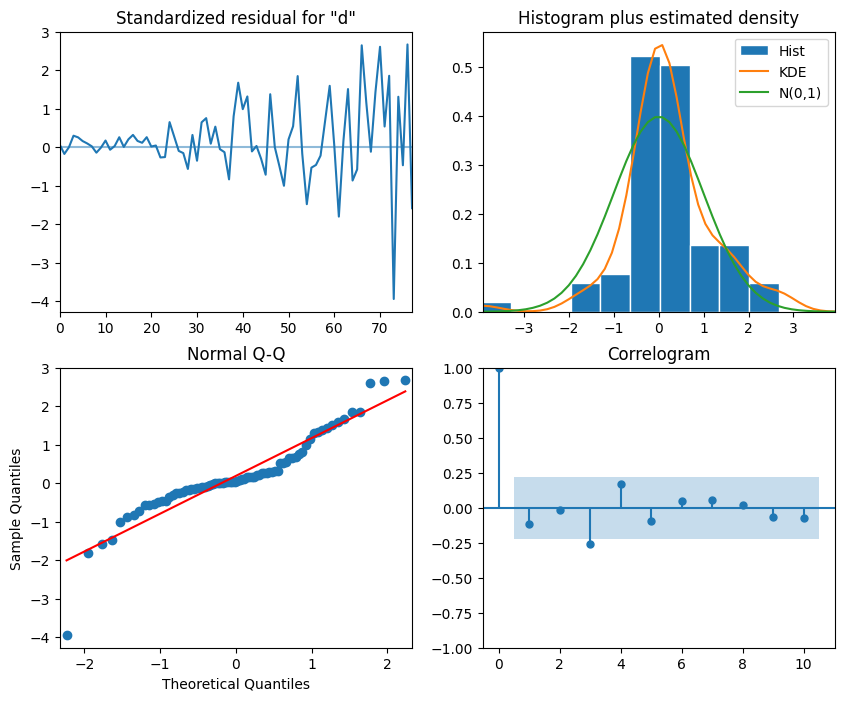

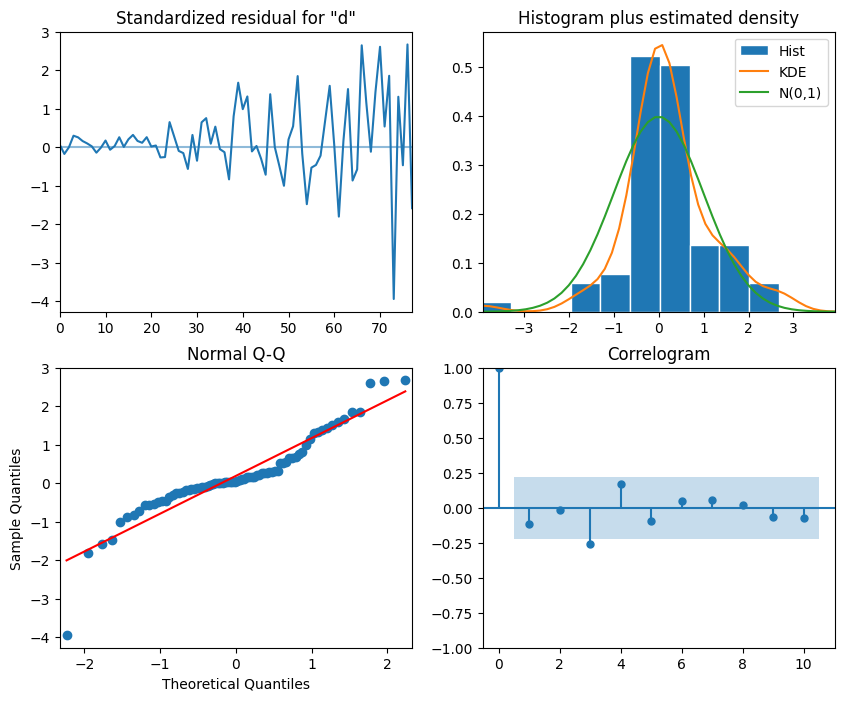

In [14]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

In [15]:
residuals = SARIMA_model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 11, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,1.664364,0.197015
2,1.666019,0.434739
3,7.330313,0.062083
4,9.307973,0.053846
5,9.923169,0.077442
6,10.147149,0.118590
7,10.385066,0.167782
8,10.422536,0.236612
9,10.756776,0.292750
10,11.218090,0.340781


Residuals are non correlated

I pick SARIMA(3,2,3)(0,0,0)_4

*******************************************************************************************
Forecast with model

In [41]:
SARIMA_model = SARIMAX(train['data'], order=(3,2,3), seasonal_order=(0,0,0,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False, method='powell')#, method='nm') # method='powell'

#print(SARIMA_model_fit.summary())

In [42]:
test['naive_seasonal'] = df['data'].iloc[76:80].values
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,10.277841
81,1980-04-01,14.67,12.96,9.424806
82,1980-07-02,16.02,14.85,9.438436
83,1980-10-01,11.61,9.99,9.465095


In [43]:
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,SARIMA_pred
80,1980-01-01,16.20,14.04,15.855217
81,1980-04-01,14.67,12.96,14.395392
82,1980-07-02,16.02,14.85,16.358811
83,1980-10-01,11.61,9.99,11.684497


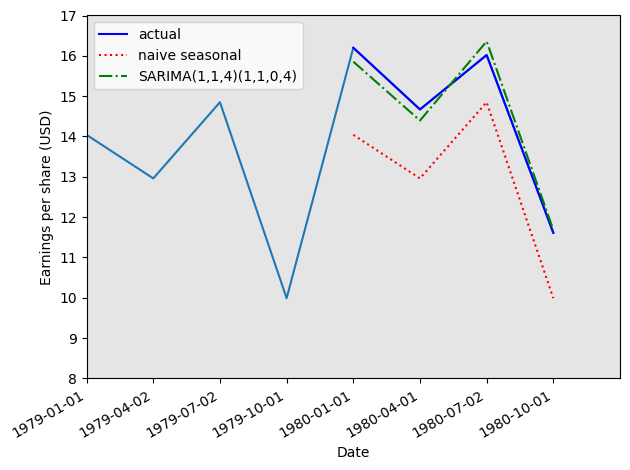

In [44]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
#ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,1,4)(1,1,0,4)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(75, 84, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(76, 84)
ax.set_ylim(8, 17)

fig.autofmt_xdate()
plt.tight_layout()


In [45]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_SARIMA)

11.561658552433654 1.6891958520946198


CH07, ARIMA(3,2,3): 1.73% off

CH08_exercise_8.5.1_d=2_D=0_recreate, SARIMA(3,2,3)(0,0,0)_4: 1.73% off  
CH08_exercise_8.5.1_d=2_D=0_recreate, SARIMA(3,2,3)(0,0,0)_4, method='Powell': 1.69% off
CH08_exercise_8.5.1_d=2_D=0_recreate, SARIMA(3,2,3)(0,0,0)_4, method='nm': 1.69% off

CH08_exercise_8.5.1_d=1_D=1, SARIMA(1,1,4)(1,1,0,4)_4: 3.49% off

CH08_exercise_8.5.1_d=0_D=1: 11.48% off

CH08_exercise_8.5.1_d=2_D=0, SARIMA(2,2,3)(1,0,2)_4: 9.62% off



NOTE:
Some models did not show Log Likelihood and other summary parameters, I started using method='nm'. But then results are quite different.